# PROGRAMA 2

## Objetivo:
- Implementación de una red neuronal para la detección de ciberacoso a partir de una recopilación de tweets (actualmente X's).erior uso.

## Tratamiento y visualización de los datos

In [1]:
#Importación de los datos
import pandas as pd
data_train = pd.read_csv('E:\MATERIAS CURSADAS\ONCEAVO SEMESTRE\PLN\cyberbullying_train.csv')
data_test = pd.read_csv('E:\MATERIAS CURSADAS\ONCEAVO SEMESTRE\PLN\cyberbullying_test.csv')
data_valid = pd.read_csv('E:\MATERIAS CURSADAS\ONCEAVO SEMESTRE\PLN\cyberbullying_val.csv')

data_train.head()

,tweet_text,cyberbullying_type
0,@AntonSirius @erinspice @prpltnkr @ChiefElk oh...,other_cyberbullying
1,"Ladies ""Bedroom Bully"" The Mix Cd By @GappyRan...",not_cyberbullying
2,RT @_bobbidana: Never thought I'd say this but...,not_cyberbullying
3,She is intellectual terrorists and world suffe...,religion
4,You saudias are not friends of Muslim idiots c...,religion


In [2]:
data_test.head()

,tweet_text,cyberbullying_type
0,"@dankmtl Yeap, as a little Propaganda Nazi for...",religion
1,@LyndseyBoo wow!! Leave lyndsey phone alone!!!...,other_cyberbullying
2,"I'm not a man, only know how to bully people :(",other_cyberbullying
3,@urgedharry @nyazpolitics @greenlinerzjm If yo...,religion
4,Calling people dumb isnt nice :( RT @tayyoung_...,ethnicity


In [3]:
data_valid.head()

,tweet_text,cyberbullying_type
0,But you idiot tagged and more also I'm a Muslim,religion
1,@SEXYLALA That's a dumb nigger never fuck LALA...,ethnicity
2,I never hear hispanics calling each other brow...,ethnicity
3,@Lenny_Banx nigger read it again such a dumb a...,ethnicity
4,She was a mean girl in high school. She and Mi...,age


In [4]:
#Bibliotecas necesarias
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
os.environ["KERAS_BACKEND"] = "torch"
import keras
import torch

torch.__version__, keras.__version__

('2.4.1+cpu', '3.5.0')

- Verificación de cadenas vacías

In [5]:
cv_train = data_train['tweet_text'].isna().sum()
cv_test = data_test['tweet_text'].isna().sum()
cv_val = data_valid['tweet_text'].isna().sum()

print(cv_train, cv_test, cv_val)

0 0 0


In [6]:
len(data_train)

33384

- Eliminación de duplicados

In [7]:
data_train = data_train.drop_duplicates(subset=['tweet_text'])
len(data_train)

32534

In [8]:
data_test = data_test.drop_duplicates(subset=['tweet_text'])
len(data_test)

7119

In [9]:
data_valid = data_valid.drop_duplicates(subset=['tweet_text'])
len(data_valid)

7118

In [10]:
data_train.sort_values(by='tweet_text', ascending=True, inplace=False)

,tweet_text,cyberbullying_type
17111,&amp; you might not get ya bitch back &amp; t...,gender
2125,@rhythmixx_ :hobbies include: fighting Mariam,other_cyberbullying
16387,I fucking hate you,gender
4867,Keeks is a bitch she curves everyone lol I w...,gender
26032,Murda Gang bitch its Gang Land,other_cyberbullying
...,...,...
31103,💕💕 the smell of blocks in the morning 💕💕,other_cyberbullying
30583,💩,other_cyberbullying
17401,😂😂😂 shame @ kat &amp; andre #MKR,not_cyberbullying
24219,😂😂😂😂😂,gender


- Eliminar cadenas de espacios

In [11]:
data_train = data_train[data_train['tweet_text'].str.strip() != '']
data_train

,tweet_text,cyberbullying_type
0,@AntonSirius @erinspice @prpltnkr @ChiefElk oh...,other_cyberbullying
1,"Ladies ""Bedroom Bully"" The Mix Cd By @GappyRan...",not_cyberbullying
2,RT @_bobbidana: Never thought I'd say this but...,not_cyberbullying
3,She is intellectual terrorists and world suffe...,religion
4,You saudias are not friends of Muslim idiots c...,religion
...,...,...
33378,Just asking which people on the planet weren't...,ethnicity
33379,Missing school for the Grey Cup festivall at N...,not_cyberbullying
33380,"Seriously, ""lady"" is what my mom calls her clo...",gender
33381,"Same as religion, one rule for muslims ,one ru...",religion


In [12]:
data_test = data_test[data_test['tweet_text'].str.strip() != '']
data_test

,tweet_text,cyberbullying_type
0,"@dankmtl Yeap, as a little Propaganda Nazi for...",religion
1,@LyndseyBoo wow!! Leave lyndsey phone alone!!!...,other_cyberbullying
2,"I'm not a man, only know how to bully people :(",other_cyberbullying
3,@urgedharry @nyazpolitics @greenlinerzjm If yo...,religion
4,Calling people dumb isnt nice :( RT @tayyoung_...,ethnicity
...,...,...
7149,@gameragodzilla @Totalbiscuit @Grummz @BenKuch...,other_cyberbullying
7150,Everyone upset about Amy Schumer's gay jokes s...,gender
7151,The way that every pyramid scheme girl was a b...,age
7152,bro you can bully the kids at school but you c...,age


In [13]:
data_valid = data_valid[data_valid['tweet_text'].str.strip() != '']
data_valid

,tweet_text,cyberbullying_type
0,But you idiot tagged and more also I'm a Muslim,religion
1,@SEXYLALA That's a dumb nigger never fuck LALA...,ethnicity
2,I never hear hispanics calling each other brow...,ethnicity
3,@Lenny_Banx nigger read it again such a dumb a...,ethnicity
4,She was a mean girl in high school. She and Mi...,age
...,...,...
7149,haha.erdogan started syrian conflict or the we...,religion
7150,@discerningmumin That's idiotic. Not holding a...,religion
7151,This is way past George Floyd. Everyone is agr...,ethnicity
7152,I'm not important. The things I'm working on a...,other_cyberbullying


- Se elimina toda la puntuación 

In [14]:
import string

In [15]:
data_train['tweet_text'] = data_train['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
data_train.head()

,tweet_text,cyberbullying_type
0,antonsirius erinspice prpltnkr chiefelk oh dea...,other_cyberbullying
1,ladies bedroom bully the mix cd by gappyranks ...,not_cyberbullying
2,rt bobbidana never thought id say this but i h...,not_cyberbullying
3,she is intellectual terrorists and world suffe...,religion
4,you saudias are not friends of muslim idiots c...,religion


In [16]:
data_test['tweet_text'] = data_test['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
data_test.head()

,tweet_text,cyberbullying_type
0,dankmtl yeap as a little propaganda nazi for t...,religion
1,lyndseyboo wow leave lyndsey phone alone bully...,other_cyberbullying
2,im not a man only know how to bully people,other_cyberbullying
3,urgedharry nyazpolitics greenlinerzjm if you a...,religion
4,calling people dumb isnt nice rt tayyoung fuc...,ethnicity


In [17]:
data_valid['tweet_text'] = data_valid['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
data_valid.head()

,tweet_text,cyberbullying_type
0,but you idiot tagged and more also im a muslim,religion
1,sexylala thats a dumb nigger never fuck lala h...,ethnicity
2,i never hear hispanics calling each other brow...,ethnicity
3,lennybanx nigger read it again such a dumb ass...,ethnicity
4,she was a mean girl in high school she and mim...,age


- Clasificación en clases de los tipos de twwets que tenemos

In [18]:
#Uso de tf.data para la clasificación de clases a partir de vectores ONE-HOT
import tensorflow as tf

#Vectores ONE-HOT del conjunto de entrenamiento, prueba y validación
vector_train = data_train['cyberbullying_type']
vector_test = data_test['cyberbullying_type']
vector_val = data_valid['cyberbullying_type']

def mapeo_one_hot(vectores):
    categorias = list(set(vectores))
    valor_categorias = {vectores: index for index, vectores in enumerate(categorias)}

    indices = [valor_categorias[vector] for vector in vectores]

    one_hot = tf.one_hot(indices, depth=len(categorias))

    return one_hot

one_hot_train = mapeo_one_hot(vector_train)
one_hot_test = mapeo_one_hot(vector_test)
one_hot_val = mapeo_one_hot(vector_val)

print(one_hot_train.numpy())

[[0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [19]:
import tensorflow as tf
from keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import time

X_train = data_train['tweet_text'].values
y_train = one_hot_train

x_test = data_test['tweet_text'].values
y_test = one_hot_test

x_val = data_valid['tweet_text'].values
y_val = one_hot_val

In [20]:
len(X_train), len(x_test), len(x_val)

(32534, 7119, 7118)

In [21]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
raw_val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [22]:
# Tamaño de vocabulario
vocab_size = 10000

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode='tf-idf')

# Obtener el texto sin etiquetas
text_ds = raw_train_ds.map(lambda x, y: x)
start = time.time()
vectorize_layer.adapt(text_ds)
print(f'Time for adapt is {time.time()-start:.4f}')

Time for adapt is 175.0320


In [23]:
batch_size = 64
raw_train_ds = raw_train_ds.shuffle(20000).batch(batch_size)
raw_test_ds = raw_test_ds.batch(batch_size)
raw_val_ds = raw_val_ds.batch(batch_size)

In [24]:
for inp, target in raw_train_ds.take(1):
    print(inp[:2], target[:2])

tf.Tensor(
[b'watching wadhwa claim that he never received financial compensation oh sweets we know this isnt how that works stopwadhwa2015'
 b'i remember the shame and anxiety i felt about telling my family and friends i was straight in high school a classmate caught me holding hands with a girl and told the whole school i was straight i was bullied mercilessly i still remember every joke and insult 10 years later'], shape=(2,), dtype=string) tf.Tensor(
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]], shape=(2, 6), dtype=float32)


In [25]:
vectorize_layer(inp)

tensor([[7.7002, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 2.4530, 2.6519,  ..., 0.0000, 0.0000, 0.0000],
        [7.7002, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [7.7002, 0.0000, 2.6519,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.2265, 1.3260,  ..., 0.0000, 0.0000, 0.0000]])

In [26]:
def preprocess(x, y):
    x = vectorize_layer(x)
    return x, y

train_ds = raw_train_ds.map(lambda x, y: preprocess(x, y))
val_ds = raw_val_ds.map(lambda x, y: preprocess(x, y))
test_ds = raw_test_ds.map(lambda x, y: preprocess(x, y))

In [27]:
next(iter(train_ds))

(<tf.Tensor: shape=(64, 10000), dtype=float32, numpy=
 array([[23.10065  ,  1.2264812,  1.3259579, ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  4.905925 ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  1.2264812,  1.3259579, ...,  0.       ,  0.       ,
          0.       ],
        ...,
        [15.400434 ,  2.4529624,  2.6519158, ...,  0.       ,  0.       ,
          0.       ],
        [ 7.700217 ,  1.2264812,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 7.700217 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ]], dtype=float32)>,
 <tf.Tensor: shape=(64, 6), dtype=float32, numpy=
 array([[0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 

- Construcción del modelo de red neuronal.

In [28]:
class Linear(keras.layers.Layer):
    def __init__(self, num_outputs, activation=None):
        super().__init__()
        self.num_outputs = num_outputs
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
      input_dim = input_shape[-1]
      self.w = self.add_weight(shape=[input_dim,
                                      self.num_outputs],
                               name = 'kernel')
      self.b = self.add_weight(shape=[self.num_outputs],
                               name = 'bias')

    def call(self, inputs):
      x = keras.ops.matmul(inputs, self.w) + self.b
      return self.activation(x)

In [29]:
test_batch = next(iter(test_ds))
test_batch[0]

<tf.Tensor: shape=(64, 10000), dtype=float32, numpy=
array([[ 7.700217 ,  1.2264812,  1.3259579, ...,  0.       ,  0.       ,
         0.       ],
       [23.10065  ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  1.3259579, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [15.400434 ,  0.       ,  1.3259579, ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  1.3259579, ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  1.2264812,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)>

In [30]:
val_batch = next(iter(val_ds))
val_batch[0]

<tf.Tensor: shape=(64, 10000), dtype=float32, numpy=
array([[ 0.       ,  0.       ,  1.3259579, ...,  0.       ,  0.       ,
         0.       ],
       [15.400434 ,  0.       ,  1.3259579, ...,  0.       ,  0.       ,
         0.       ],
       [15.400434 ,  2.4529624,  1.3259579, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  1.3259579, ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [15.400434 ,  1.2264812,  1.3259579, ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)>

In [34]:
from tensorflow.keras.layers import Dropout 

class Model(keras.Model):
    def __init__(self, activation):
        super().__init__()
        self.l1 = Linear(24, activation=activation)
        Dropout(0.5)
        self.l2 = Linear(18)
        Dropout(0.5)
        self.l3 = Linear(18, activation=activation)
        Dropout(0.5)
        self.l4 = Linear(18)
        Dropout(0.5)
        self.l5 = Linear(6, activation=activation)
     

    def call(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        return x

model = Model('softmax')

In [35]:
model(test_batch[0]).shape, test_batch[1].shape

(torch.Size([64, 6]), TensorShape([64, 6]))

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Definir los callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4),  # Detener cuando la pérdida de validación no mejore por 3 épocas consecutivas.
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)  # Guardar el mejor modelo.
]

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks,
    batch_size=val_batch
)

y_pred_score = model.predict(
    test_ds,
    callbacks=callbacks
)


model.evaluate(
    test_ds,
    batch_size=test_batch
)

Epoch 1/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.3647 - loss: 1.6131 - val_accuracy: 0.7227 - val_loss: 0.7037
Epoch 2/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.7965 - loss: 0.5404 - val_accuracy: 0.8050 - val_loss: 0.4876
Epoch 3/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.8854 - loss: 0.3065 - val_accuracy: 0.8192 - val_loss: 0.5101
Epoch 4/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9335 - loss: 0.1966 - val_accuracy: 0.8113 - val_loss: 0.5802
Epoch 5/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9602 - loss: 0.1309 - val_accuracy: 0.8070 - val_loss: 0.6716
Epoch 6/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9714 - loss: 0.0944 - val_accuracy: 0.7952 - val_loss: 0.7903
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8036 - loss: 0.7558


[0.7700995206832886, 0.8034836649894714]

In [37]:
history.history

{'accuracy': [0.5319050550460815,
  0.8153316378593445,
  0.8892850279808044,
  0.9308415651321411,
  0.9561074376106262,
  0.9700620770454407],
 'loss': [1.274846076965332,
  0.4787665009498596,
  0.29345759749412537,
  0.19718673825263977,
  0.1340521275997162,
  0.09549491852521896],
 'val_accuracy': [0.7226749062538147,
  0.8050013780593872,
  0.8191908001899719,
  0.8113234043121338,
  0.8069682717323303,
  0.7951672077178955],
 'val_loss': [0.7036875486373901,
  0.4875989258289337,
  0.5100648403167725,
  0.5801635384559631,
  0.6715729236602783,
  0.790323793888092]}

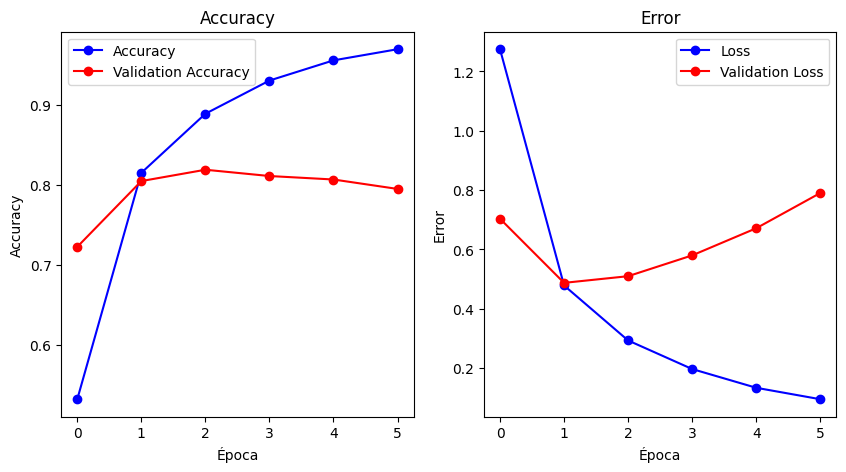

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot de accuracy en el primer subplot
ax1.plot(history.history['accuracy'], 'bo-', label='Accuracy')
ax1.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Época')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot de error en el segundo subplot
ax2.plot(history.history['loss'], 'bo-', label='Loss')
ax2.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
ax2.set_title('Error')
ax2.set_xlabel('Época')
ax2.set_ylabel('Error')
ax2.legend()

# Mostrar figura
plt.show()

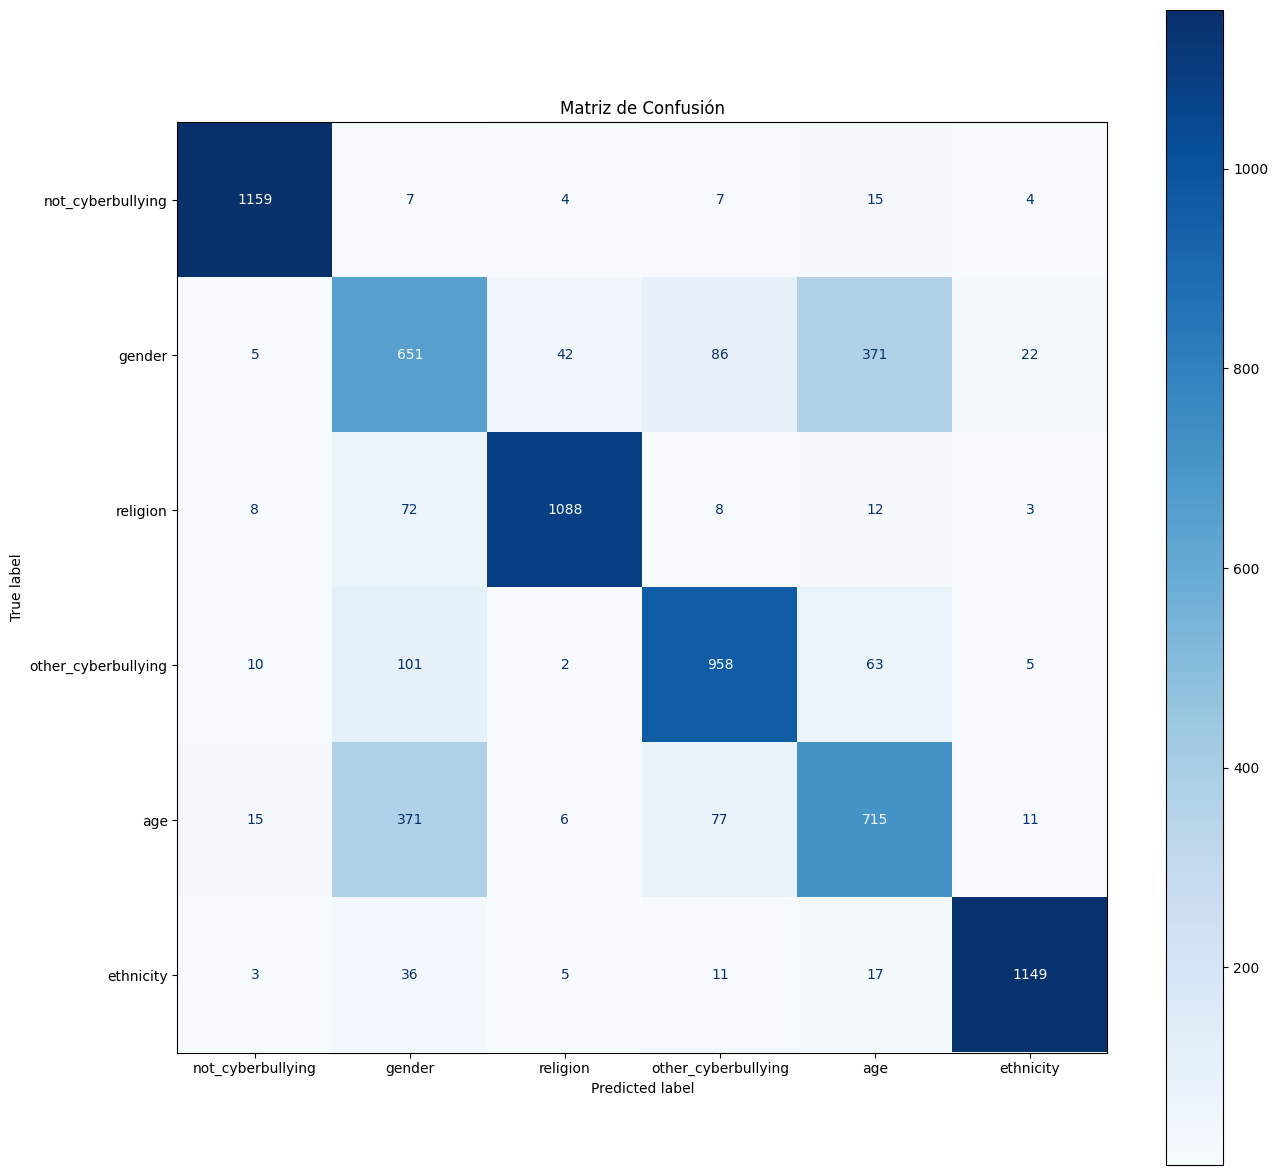

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(y_pred_score, axis=1)
y_true = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)

nombres_clase = ['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying', 'age', 'ethnicity']

plt.figure(figsize=(15,15))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=nombres_clase)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Matriz de Confusión")
plt.show()